In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

In [2]:
# --- 1. Définition du Problème ---
def f(X):
    return X[0]**2 + X[1]**2

def grad_f(X):
    return np.array([2*X[0], 2*X[1]])

In [ ]:
# --- 2. Moteur de Descente de Gradient (Sous-problème) ---
def descente_gradient(grad_total_func, X_start, tau, epsilon_inner, max_iter_inner):
    """
    Résout le sous-problème.
    Inclut une sécurité (gradient clipping) pour éviter l'explosion numérique.
    """
    X = np.array(X_start, dtype=float)
    
    for k in range(max_iter_inner):
        g = grad_total_func(X)
        
        # --- SÉCURITÉ ANTI-EXPLOSION ---
        # Si la norme du gradient est trop grande, on la limite (clipping)
        norm_g = np.linalg.norm(g)
        if norm_g > 100.0: 
            g = g / norm_g * 100.0
            
        X_new = X - tau * g
        
        # Protection contre les NaN (Not a Number)
        if np.any(np.isnan(X_new)):
            print("   [Alerte] Instabilité numérique détectée, arrêt du sous-problème.")
            return X
            
        if np.linalg.norm(X_new - X) < epsilon_inner:
            return X_new
        X = X_new
        
    return X

In [7]:
# --- 3. Méthode de Pénalisation EXTERNE ---
def penalisation_externe(X0, tau, N_outer, mu_start, factor):
    X = np.array(X0, dtype=float)
    mu = mu_start
    path = [X.copy()]
    history = []

    print(f"--- Pénalisation EXTERNE (Départ {X0}) ---")
    
    for k in range(N_outer):
        # Fonction gradient locale
        def grad_penalise(X_curr):
            # Grad P = 2 * (x + y - 1) * [1, 1]
            grad_P = 2 * (X_curr[0] + X_curr[1] - 1) * np.array([1., 1.])
            return grad_f(X_curr) + mu * grad_P
        
        # On réduit légèrement le tau si mu devient très grand pour stabiliser
        tau_actuel = tau / (1 + 0.1*k) 
        
        X_sol = descente_gradient(grad_penalise, X, tau_actuel, 1e-5, 2000)
        
        err = abs(X_sol[0] + X_sol[1] - 1)
        history.append({'Iter': k+1, 'Mu': mu, 'X': np.round(X_sol, 4), 'Err_Contr': err})
        path.append(X_sol.copy())
        
        X = X_sol
        mu = mu * factor 
        
    return np.array(path), pd.DataFrame(history)

In [8]:
# --- 4. Méthode de Pénalisation INTERNE ---
def penalisation_interne(X0, tau, N_outer, mu_start, factor):
    X = np.array(X0, dtype=float)
    mu = mu_start
    path = [X.copy()]
    history = []
    
    if X[0] + X[1] <= 1:
        print("ERREUR: Le point de départ interne doit vérifier x+y > 1")
        return np.array(path), pd.DataFrame()

    print(f"--- Pénalisation INTERNE (Départ {X0}) ---")

    for k in range(N_outer):
        def grad_penalise(X_curr):
            denom = (X_curr[0] + X_curr[1] - 1)
            # Sécurité division par zéro
            if denom <= 1e-8: denom = 1e-8
            
            # Grad B = -1/(x+y-1) * [1, 1]
            grad_B = - (1.0 / denom) * np.array([1., 1.])
            return grad_f(X_curr) + mu * grad_B
        
        X_sol = descente_gradient(grad_penalise, X, tau, 1e-5, 2000)
        
        dist = X_sol[0] + X_sol[1] - 1
        history.append({'Iter': k+1, 'Mu': mu, 'X': np.round(X_sol, 4), 'Dist_Bord': dist})
        path.append(X_sol.copy())
        
        X = X_sol
        mu = mu / factor 
        
    return np.array(path), pd.DataFrame(history)

--- Pénalisation EXTERNE (Départ [-1.0, -1.0]) ---
--- Pénalisation INTERNE (Départ [2.0, 2.0]) ---


/home/abdeslem/Folders/2CS/S1/MASD/TPs/venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2767: RuntimeWarning: overflow encountered in dot
  sqnorm = x.dot(x)
/tmp/ipykernel_197878/1815785294.py:15: RuntimeWarning: overflow encountered in multiply
  return grad_f(X_curr) + mu * grad_P
/tmp/ipykernel_197878/1830430729.py:9: RuntimeWarning: invalid value encountered in subtract
  X_new = X - tau * g


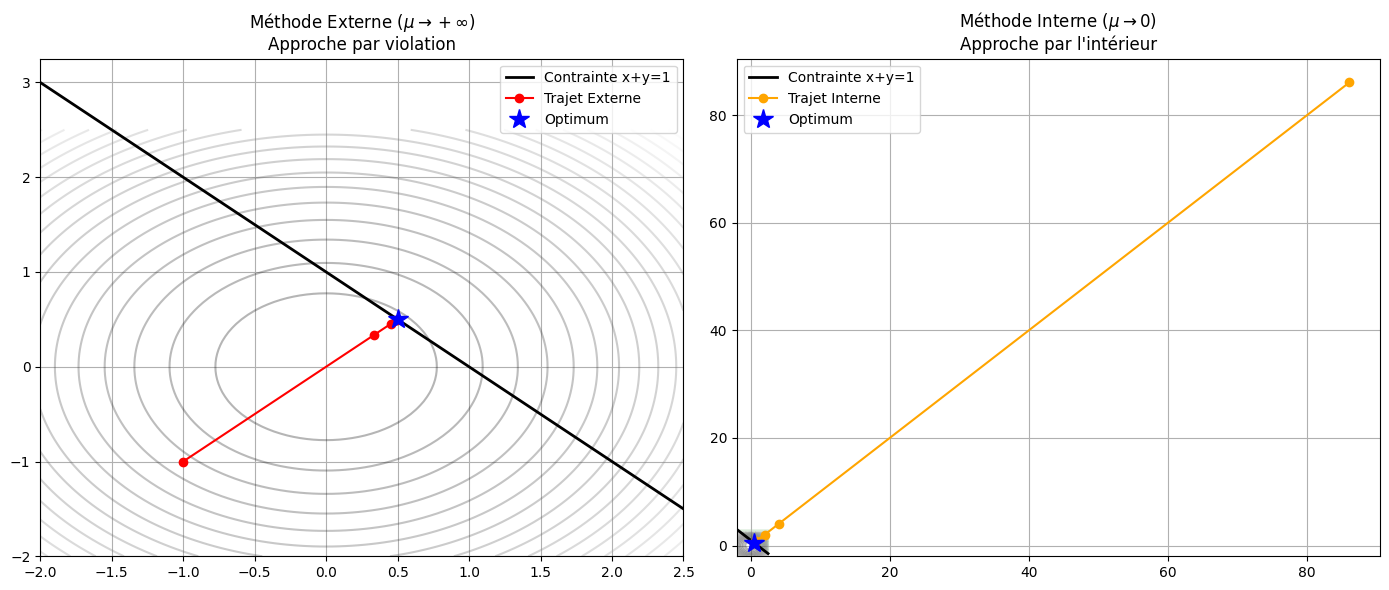


--- Résultats Externe ---
 Iter   Mu                X  Err_Contr
    1    1 [0.3331, 0.3331]   0.333786
    2    5 [0.4545, 0.4545]   0.091032
    3   25 [0.4902, 0.4902]   0.019626
    4  125   [0.498, 0.498]   0.003991
    5  625       [nan, nan]        NaN
    6 3125       [nan, nan]        NaN

--- Résultats Interne ---
 Iter      Mu                  X  Dist_Bord
    1 1.00000   [0.8092, 0.8092]   0.618402
    2 0.20000   [0.5855, 0.5855]   0.170976
    3 0.04000   [0.5193, 0.5193]   0.038552
    4 0.00800     [0.504, 0.504]   0.007938
    5 0.00160   [4.0502, 4.0502]   7.100401
    6 0.00032 [86.0669, 86.0669] 171.133838


In [10]:
# --- 5. Exécution ---
# Paramètres plus doux pour éviter l'explosion immédiate
tau = 0.005 
N_steps = 6

path_ext, df_ext = penalisation_externe([-1.0, -1.0], tau, N_steps, mu_start=1, factor=5)
path_int, df_int = penalisation_interne([2.0, 2.0], tau, N_steps, mu_start=1, factor=5)

# --- 6. Visualisation ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

x_grid = np.linspace(-2, 2.5, 100)
y_grid = np.linspace(-2, 2.5, 100)
X_g, Y_g = np.meshgrid(x_grid, y_grid)
Z = X_g**2 + Y_g**2

# Graphique Externe
ax1.contour(X_g, Y_g, Z, levels=20, cmap='gray', alpha=0.3)
ax1.plot(x_grid, 1-x_grid, 'k-', linewidth=2, label='Contrainte x+y=1')
ax1.plot(path_ext[:,0], path_ext[:,1], 'o-', color='red', label='Trajet Externe')
ax1.plot(0.5, 0.5, 'b*', markersize=15, label='Optimum')
# CORRECTION SYNTAXIQUE ICI (r"...")
ax1.set_title(r"Méthode Externe ($\mu \to +\infty$)" + "\nApproche par violation")
ax1.legend()
ax1.grid()

# Graphique Interne
ax2.contour(X_g, Y_g, Z, levels=20, cmap='gray', alpha=0.3)
ax2.plot(x_grid, 1-x_grid, 'k-', linewidth=2, label='Contrainte x+y=1')
ax2.fill_between(x_grid, 1-x_grid, 3, color='green', alpha=0.1)
ax2.plot(path_int[:,0], path_int[:,1], 'o-', color='orange', label='Trajet Interne')
ax2.plot(0.5, 0.5, 'b*', markersize=15, label='Optimum')
# CORRECTION SYNTAXIQUE ICI (r"...")
ax2.set_title(r"Méthode Interne ($\mu \to 0$)" + "\nApproche par l'intérieur")
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

# Affichage des données
print("\n--- Résultats Externe ---")
print(df_ext[['Iter', 'Mu', 'X', 'Err_Contr']].to_string(index=False))
print("\n--- Résultats Interne ---")
print(df_int[['Iter', 'Mu', 'X', 'Dist_Bord']].to_string(index=False))

--- Exécution du Benchmark en cours... ---

=== RÉSULTATS DU BENCHMARK ===
Methode  Facteur  Pas (tau)  Total Iters  Temps (s)  Erreur Finale
Externe        2      0.010         8291     0.2385        2.94239
Externe       10      0.010        16170     0.4200        2.51336
Interne        2      0.010         6360     0.1465        0.20142
Interne       10      0.010        14354     0.2767        0.00049
Externe       10      0.001        15344     0.3940        0.25921
Interne       10      0.050        14101     0.2866        0.00009


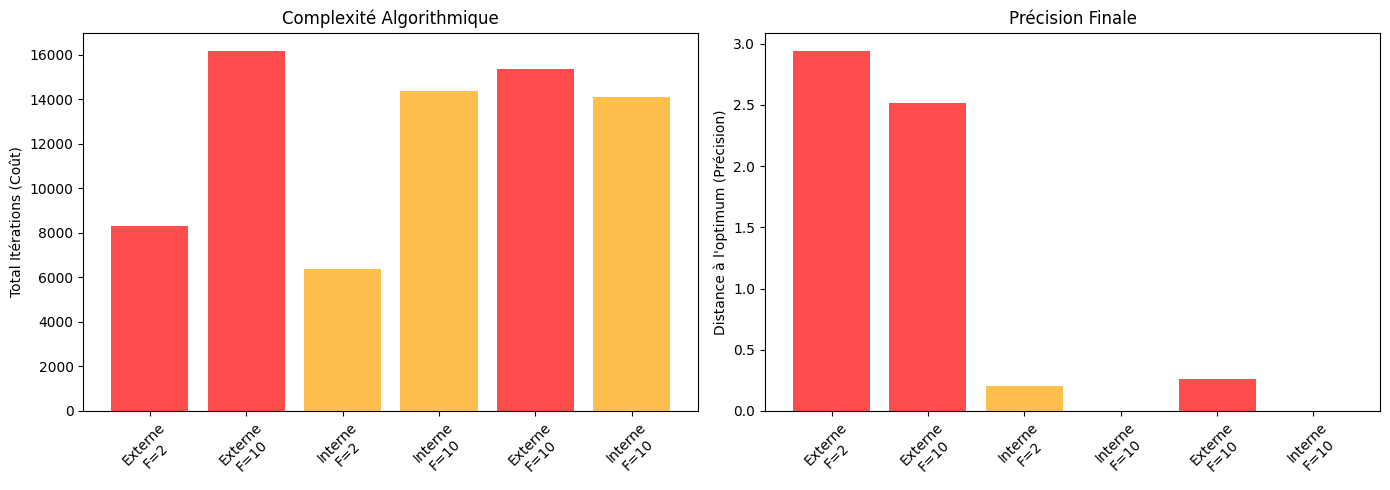

In [11]:
"""
Le Code de Benchmark Complet
Ce script lance plusieurs scénarios 
(en faisant varier le facteur de croissance de mu et le pas tau) 
et enregistre tout dans un tableau comparatif.
"""
# --- 1. Définitions du Problème ---
THEORIQUE = np.array([0.5, 0.5])

def f(X): return X[0]**2 + X[1]**2
def grad_f(X): return np.array([2*X[0], 2*X[1]])

# --- 2. Moteur d'Optimisation (Boîte Noire) ---
def solve_subproblem(grad_func, X_start, tau, max_iter):
    X = X_start.copy()
    iters = 0
    for k in range(max_iter):
        g = grad_func(X)
        
        # Clipping pour éviter NaN si mu est trop gros
        norm_g = np.linalg.norm(g)
        if norm_g > 500: g = g / norm_g * 500
        
        X_new = X - tau * g
        iters += 1
        
        if np.linalg.norm(X_new - X) < 1e-5:
            break
        X = X_new
    return X, iters

# --- 3. Wrapper Pénalisation EXTERNE ---
def run_externe(params):
    start_time = time.time()
    X = np.array(params['X0'], dtype=float)
    mu = params['mu_start']
    total_iters = 0
    
    for k in range(params['N_outer']):
        # Grad P = 2*(x+y-1)
        def grad_pen(X_c):
            return grad_f(X_c) + mu * 2 * (X_c[0] + X_c[1] - 1) * np.array([1., 1.])
        
        X, it = solve_subproblem(grad_pen, X, params['tau'], 2000)
        total_iters += it
        mu *= params['factor'] # Augmente mu
        
    duration = time.time() - start_time
    dist_opt = np.linalg.norm(X - THEORIQUE)
    
    return {
        'Methode': 'Externe',
        'Facteur': params['factor'],
        'Pas (tau)': params['tau'],
        'Temps (s)': round(duration, 4),
        'Total Iters': total_iters,
        'Erreur Finale': round(dist_opt, 5),
        'X_final': np.round(X, 3)
    }

# --- 4. Wrapper Pénalisation INTERNE ---
def run_interne(params):
    start_time = time.time()
    X = np.array(params['X0'], dtype=float)
    mu = params['mu_start']
    total_iters = 0
    
    # Vérification sécurité
    if X[0] + X[1] <= 1:
        return {'Methode': 'Interne (Fail)', 'Erreur Finale': 999}

    for k in range(params['N_outer']):
        # Grad B = -1/(x+y-1)
        def grad_pen(X_c):
            denom = X_c[0] + X_c[1] - 1
            if denom < 1e-9: denom = 1e-9
            return grad_f(X_c) - mu * (1./denom) * np.array([1., 1.])
        
        X, it = solve_subproblem(grad_pen, X, params['tau'], 2000)
        total_iters += it
        mu /= params['factor'] # Diminue mu
        
    duration = time.time() - start_time
    dist_opt = np.linalg.norm(X - THEORIQUE)
    
    return {
        'Methode': 'Interne',
        'Facteur': params['factor'],
        'Pas (tau)': params['tau'],
        'Temps (s)': round(duration, 4),
        'Total Iters': total_iters,
        'Erreur Finale': round(dist_opt, 5),
        'X_final': np.round(X, 3)
    }

# --- 5. Lancement du Benchmark ---
results = []

# Scénarios à tester
# On fait varier le Facteur (vitesse de durcissement) et le Pas (tau)
scenarios = [
    # Test Facteur (Impact de la vitesse de pénalisation)
    {'type': 'ext', 'X0': [-1, -1], 'mu': 1, 'factor': 2,  'tau': 0.01, 'N': 10},
    {'type': 'ext', 'X0': [-1, -1], 'mu': 1, 'factor': 10, 'tau': 0.01, 'N': 10},
    
    # Test Interne (Nécessite bon point de départ)
    {'type': 'int', 'X0': [2, 2],   'mu': 1, 'factor': 2,  'tau': 0.01, 'N': 10},
    {'type': 'int', 'X0': [2, 2],   'mu': 1, 'factor': 10, 'tau': 0.01, 'N': 10},
    
    # Test Impact du Pas (Tau)
    {'type': 'ext', 'X0': [-1, -1], 'mu': 1, 'factor': 10, 'tau': 0.001, 'N': 10}, # Pas lent
    {'type': 'int', 'X0': [2, 2],   'mu': 1, 'factor': 10, 'tau': 0.05,  'N': 10}, # Pas rapide
]

print("--- Exécution du Benchmark en cours... ---")

for sc in scenarios:
    p = {
        'X0': sc['X0'], 
        'mu_start': sc['mu'], 
        'factor': sc['factor'], 
        'tau': sc['tau'], 
        'N_outer': sc['N']
    }
    
    if sc['type'] == 'ext':
        res = run_externe(p)
    else:
        res = run_interne(p)
    results.append(res)

# Création du DataFrame
df = pd.DataFrame(results)

# --- 6. Affichage et Analyse ---
print("\n=== RÉSULTATS DU BENCHMARK ===")
# Réorganisation des colonnes pour la lisibilité
cols = ['Methode', 'Facteur', 'Pas (tau)', 'Total Iters', 'Temps (s)', 'Erreur Finale']
print(df[cols].to_string(index=False))

# --- 7. Visualisation Graphique (Bar Chart) ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1 : Complexité (Itérations)
colors = ['red' if 'Externe' in m else 'orange' for m in df['Methode']]
ax[0].bar(range(len(df)), df['Total Iters'], color=colors, alpha=0.7)
ax[0].set_xticks(range(len(df)))
ax[0].set_xticklabels([f"{r['Methode']}\nF={r['Facteur']}" for i, r in df.iterrows()], rotation=45)
ax[0].set_ylabel("Total Itérations (Coût)")
ax[0].set_title("Complexité Algorithmique")

# Graphique 2 : Précision (Erreur)
ax[1].bar(range(len(df)), df['Erreur Finale'], color=colors, alpha=0.7)
ax[1].set_xticks(range(len(df)))
ax[1].set_xticklabels([f"{r['Methode']}\nF={r['Facteur']}" for i, r in df.iterrows()], rotation=45)
ax[1].set_ylabel("Distance à l'optimum (Précision)")
ax[1].set_title("Précision Finale")

plt.tight_layout()
plt.show()

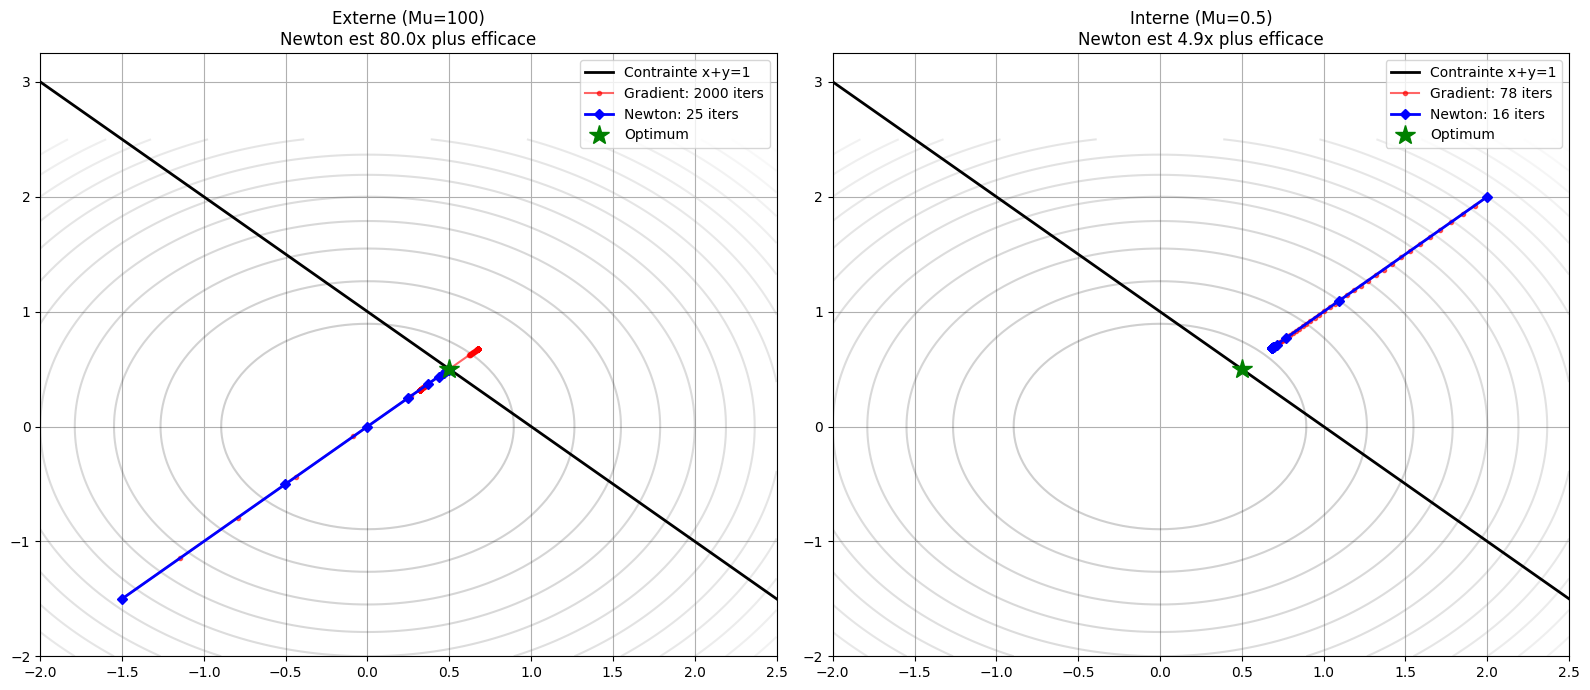

Méthode    | Algo       | Itérations
-----------------------------------
Externe    | Gradient   | 2000
Externe    | Newton     | 25
-----------------------------------
Interne    | Gradient   | 78
Interne    | Newton     | 16


In [13]:
# -- Implémentation : Newton vs Gradient --

# --- Paramètres Globaux ---
ALPHA_NEWTON = 0.5  # "Frein" pour Newton (0.5 = demi-pas) pour mieux visualiser
CLIP_VALUE = 100.0  # Valeur max du gradient pour éviter l'explosion

def f(X): return X[0]**2 + X[1]**2
def grad_f(X): return np.array([2*X[0], 2*X[1]])

# --- MOTEUR 1 : Gradient Descent ---
def solve_gradient(grad_func, X0, tau, max_iter=2000):
    X = X0.copy()
    path = [X.copy()]
    iters = 0
    
    for k in range(max_iter):
        g = grad_func(X)
        
        # 1. Clipping : Empêche g de devenir infini
        norm_g = np.linalg.norm(g)
        if norm_g > CLIP_VALUE:
            g = g / norm_g * CLIP_VALUE
            
        # 2. Descente
        X_new = X - tau * g
        
        # 3. Sécurité NaN
        if np.any(np.isnan(X_new)):
            break
            
        X = X_new
        path.append(X.copy())
        iters += 1
        
        if np.linalg.norm(g) < 1e-4: break
            
    return X, np.array(path), iters

# --- MOTEUR 2 : Newton AMORTI  ---
def solve_newton(grad_func, hess_func, X0, max_iter=100, is_internal=False):
    X = X0.copy()
    path = [X.copy()]
    iters = 0
    
    for k in range(max_iter):
        g = grad_func(X)
        H = hess_func(X)
        
        # Inversion Hessien + Direction
        try:
            H_inv = np.linalg.inv(H)
            direction = - H_inv @ g
        except np.linalg.LinAlgError:
            direction = -g # Fallback sur gradient si singulier

        # Newton Amorti (Damped) : on ne prend qu'une fraction du pas
        step_size = ALPHA_NEWTON 
        
        # Pour la méthode interne, on doit vérifier qu'on ne sort pas des bornes
        if is_internal:
            # Backtracking simple : si on touche le mur, on réduit le pas
            for _ in range(10):
                X_test = X + step_size * direction
                if X_test[0] + X_test[1] > 1.0001: # Si on est toujours dans la zone admissible
                    break
                step_size *= 0.5 # On réduit le pas
        
        X = X + step_size * direction
        path.append(X.copy())
        iters += 1
        
        if np.linalg.norm(g) < 1e-4: break
            
    return X, np.array(path), iters

# --- SETUP : Pénalisation EXTERNE ---
def run_externe():
    X0 = np.array([-1.5, -1.5])
    mu = 100.0 # Une valeur moyenne pour voir l'effet
    
    # Définitions Maths
    def grad_ext(X):
        return grad_f(X) + mu * 2 * (X[0] + X[1] - 1) * np.array([1., 1.])
    
    def hess_ext(X):
        val = 2 + 2*mu
        return np.array([[val, 2*mu], [2*mu, val]])
    
    # Calculs
    # Note: On prend un petit tau pour le gradient car mu=100
    sol_g, path_g, it_g = solve_gradient(grad_ext, X0, tau=0.005) 
    sol_n, path_n, it_n = solve_newton(grad_ext, hess_ext, X0)
    
    return path_g, path_n, it_g, it_n, "Externe (Mu=100)"

# --- SETUP : Pénalisation INTERNE ---
def run_interne():
    X0 = np.array([2.0, 2.0]) # Départ valide
    mu = 0.5 # Barrière modérée
    
    # Définitions Maths
    def grad_int(X):
        denom = X[0] + X[1] - 1
        if denom < 1e-8: denom = 1e-8
        return grad_f(X) - (mu / denom) * np.array([1., 1.])
    
    def hess_int(X):
        denom = X[0] + X[1] - 1
        if denom < 1e-8: denom = 1e-8
        term = mu / (denom**2)
        return np.array([[2, 0], [0, 2]]) + term * np.array([[1, 1], [1, 1]])
    
    # Calculs
    sol_g, path_g, it_g = solve_gradient(grad_int, X0, tau=0.02)
    sol_n, path_n, it_n = solve_newton(grad_int, hess_int, X0, is_internal=True)
    
    return path_g, path_n, it_g, it_n, "Interne (Mu=0.5)"

# --- EXECUTION & PLOT ---
res_ext = run_externe()
res_int = run_interne()

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Fonction de tracé générique
def plot_results(ax, res, title):
    path_g, path_n, it_g, it_n, name = res
    
    # Fond
    x_g = np.linspace(-2, 2.5, 100)
    y_g = np.linspace(-2, 2.5, 100)
    X, Y = np.meshgrid(x_g, y_g)
    ax.contour(X, Y, X**2+Y**2, levels=15, cmap='gray', alpha=0.2)
    ax.plot(x_g, 1-x_g, 'k-', lw=2, label='Contrainte x+y=1')
    
    # Gradient (Rouge)
    ax.plot(path_g[:,0], path_g[:,1], 'o-', color='red', markersize=3, alpha=0.6, 
            label=f'Gradient: {it_g} iters')
    
    # Newton (Bleu)
    ax.plot(path_n[:,0], path_n[:,1], 'D-', color='blue', markersize=5, linewidth=2, 
            label=f'Newton: {it_n} iters')
    
    ax.plot(0.5, 0.5, 'g*', markersize=15, label='Optimum')
    ax.set_title(f"{name}\nNewton est {it_g/it_n:.1f}x plus efficace")
    ax.legend()
    ax.grid()

plot_results(axes[0], res_ext, "Pénalisation EXTERNE")
plot_results(axes[1], res_int, "Pénalisation INTERNE")

plt.tight_layout()
plt.show()

# Petit tableau récapitulatif
print(f"{'Méthode':<10} | {'Algo':<10} | {'Itérations':<10}")
print("-" * 35)
print(f"Externe    | Gradient   | {res_ext[2]}")
print(f"Externe    | Newton     | {res_ext[3]}")
print("-" * 35)
print(f"Interne    | Gradient   | {res_int[2]}")
print(f"Interne    | Newton     | {res_int[3]}")